# Molecular dynamics simulations of bulk water

In this example, we show how to perform molecular dynamics of bulk water using the popular interatomic TIP3P potential
([W. L. Jorgensen et. al.](https://doi.org/10.1063/1.445869)) and [LAMMPS](http://lammps.sandia.gov/).

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
from pyiron.project import Project
import ase.units as units

In [2]:
pr = Project("tip3p_water")

## Creating the initial structure

We will setup a cubic simulation box consisting of 27 water molecules density density is 1 g/cm$^3$. The target density is achieved by determining the required size of the simulation cell and repeating it in all three spatial dimensions

In [3]:
density = 1.0e-24  # g/A^3
n_mols = 27
mol_mass_water = 18.015 # g/mol

# Determining the supercell size size
mass = mol_mass_water * n_mols / units.mol  # g
vol_h2o = mass / density # in A^3
a = vol_h2o ** (1./3.) # A

# Constructing the unitcell
n = int(round(n_mols ** (1. / 3.)))

dx = 0.7
r_O = [0, 0, 0]
r_H1 = [dx, dx, 0]
r_H2 = [-dx, dx, 0]
unit_cell = (a / n) * np.eye(3)
water = pr.create_atoms(elements=['H', 'H', 'O'], 
                        positions=[r_H1, r_H2, r_O], 
                        cell=unit_cell)
water.set_repeat([n, n, n])
water.plot3d()

NGLWidget()

In [4]:
water.get_chemical_formula()

'H54O27'

## Equilibrate water structure

The initial water structure is obviously a poor starting point and requires equilibration (Due to the highly artificial structure a MD simulation with a standard time step of 1fs shows poor convergence). Molecular dynamics using a time step that is two orders of magnitude smaller allows us to generate an equilibrated water structure. We use the NVT ensemble for this calculation:

In [5]:
job_name = "water_slow"
ham = pr.create_job("Lammps", job_name)
ham.structure = water
# Listing available potentials for this structure
ham.list_potentials()

['H2O_tip3p', 'H2O_tip3p_slab']

We will use the `H2O_tip3p` potential. The `H2O_tip3p_slab` should be used if you want to switch off the periodic boundary conditions along the z-axis  

In [6]:
ham.potential = 'H2O_tip3p'
ham.calc_md(temperature=300, 
            n_ionic_steps=1e4, 
            time_step=0.01)
ham.run()

In [7]:
view = ham.animate_structure()
view

NGLWidget(count=101)

## Full equilibration

At the end of this simulation, we have obtained a structure that approximately resembles water. Now we increase the time step to get a reasonably equilibrated structure 

In [8]:
# Get the final structure from the previous simulation
struct = ham.get_structure(iteration_step=-1)
job_name = "water_fast"
ham_eq = pr.create_job("Lammps", job_name)
ham_eq.structure = struct
ham_eq.potential = 'H2O_tip3p'
ham_eq.calc_md(temperature=300, 
               n_ionic_steps=1e4,
               n_print=10, 
               time_step=1)
ham_eq.run()

In [9]:
view = ham_eq.animate_structure()
view

NGLWidget(count=1001)

We can now plot the trajectories

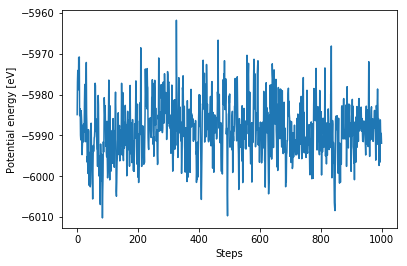

In [10]:
plt.plot(ham_eq["output/generic/energy_pot"])
plt.xlabel("Steps")
plt.ylabel("Potential energy [eV]");

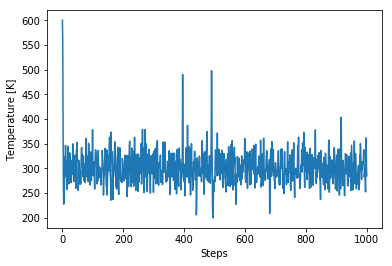

In [11]:
plt.plot(ham_eq["output/generic/temperature"])
plt.xlabel("Steps")
plt.ylabel("Temperature [K]");

## Structure analysis

We will now use the `get_neighbors()` function to determine structural properties from the computed trajectories. We take advantage of the fact that the TIP3P water model is a rigid water model which means the neighbors of each molecule never change. Therefore they need to be indexed only once

In [12]:
final_struct = ham_eq.get_structure(iteration_step=-1)

# Get the indices based on species
O_indices = final_struct.select_index("O")
H_indices = final_struct.select_index("H")

# Getting only the first two neighbors
neighbors = final_struct.get_neighbors(num_neighbors=2)

### Distribution of the O-H bond length

Every O atom has two H atoms as immediate neighbors. The distribution of this bond length is obtained by:

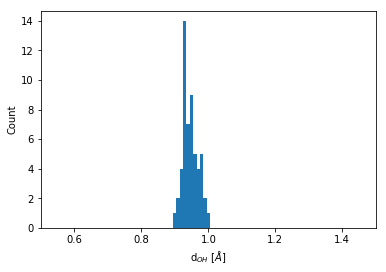

In [13]:
bins = np.linspace(0.5, 1.5, 100)
plt.hist(neighbors.distances[O_indices].flatten(), bins=bins)
plt.xlim(0.5, 1.5)
plt.xlabel(r"d$_{OH}$ [$\AA$]")
plt.ylabel("Count");

### Distribution of the O-O bond lengths

We need to extend the analysis to go beyond nearest neighbors. We do this by controlling the cutoff distance

In [14]:
neighbors = final_struct.get_neighbors(cutoff_radius=8)

In [15]:
neigh_indices = np.hstack(neighbors.indices[O_indices])
neigh_distances = np.hstack(neighbors.distances[O_indices])

One is often intended in an element specific pair correlation function. To obtain for example, the O-O coordination function, we do the following:

In [16]:
# Getting the neighboring Oxyhen indices
O_neigh_indices  = np.in1d(neigh_indices, O_indices) 
O_neigh_distances = neigh_distances[O_neigh_indices]

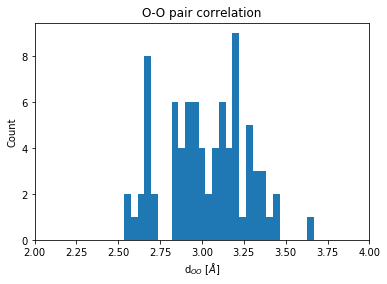

In [17]:
bins = np.linspace(1, 5, 100)
count = plt.hist(O_neigh_distances, bins=bins)
plt.xlim(2, 4)
plt.title("O-O pair correlation")
plt.xlabel(r"d$_{OO}$ [$\AA$]")
plt.ylabel("Count");